In [1]:
import dataset3

In [2]:
data3 = dataset3.load_data(1)

In [3]:
import rec3
reload (rec3)

<module 'rec3' from 'rec3.pyc'>

ae

In [4]:
import torch
import torch.nn as nn
import os
import numpy as np

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd



In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.representations = dict()
        self.encoder = nn.utils.weight_norm(nn.Linear(input_size, hidden_size))
        self.relu = nn.ReLU()
        self.decoder = nn.utils.weight_norm(nn.Linear(hidden_size, output_size))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.encoder(x)
        self.representations['hidden'] = out.data.numpy().copy()
        out = self.relu(out)
        self.representations['hidden_relu'] = out.data.numpy().copy()
        out = self.decoder(out)
        self.representations['decode'] = out.data.numpy().copy()
        out = self.sigmoid(out)
        self.representations['decode_sigmoid'] = out.data.numpy().copy()
        return out

In [7]:
def rec_pred(pred_ratings):
    pred = rec3.Rec()
    pred.set_prediction_matrix(data3.train_dataset.known, pred_ratings)
    pred.produce_rec_list(data3.train_dataset.known,targets=data3.test_dataset.targets)
    pred.evaluate(test= data3.test_dataset.test, rec_len=5)
    return pred

In [8]:
tmp = np.random.random(data3.train_dataset.train.shape)
rec_pred(pred_ratings=tmp).precision_

0.024172185430463577

In [9]:
who

DataLoader	 Dataset	 Net	 Variable	 data3	 dataset3	 nn	 np	 os	 
pd	 plt	 rec3	 rec_pred	 tmp	 torch	 


training example with input

In [10]:
input_size = 6040
hidden_size = 350
output_size = 6040
loss_history = list()
learning_rate = 0.001



num_epochs = 10

cv = 1



Net (
  (encoder): Linear (6040 -> 350)
  (relu): ReLU ()
  (decoder): Linear (350 -> 6040)
  (sigmoid): Sigmoid ()
)
Epoch [1/10], Step [1/39], Loss: 0.2501
Epoch [1/10], Step [2/39], Loss: 0.2449
Epoch [1/10], Step [3/39], Loss: 0.2341
Epoch [1/10], Step [4/39], Loss: 0.2225
Epoch [1/10], Step [5/39], Loss: 0.1998
Epoch [1/10], Step [6/39], Loss: 0.1824
Epoch [1/10], Step [7/39], Loss: 0.1669
Epoch [1/10], Step [8/39], Loss: 0.1444
Epoch [1/10], Step [9/39], Loss: 0.1409
Epoch [1/10], Step [10/39], Loss: 0.1348
Epoch [1/10], Step [11/39], Loss: 0.1183
Epoch [1/10], Step [12/39], Loss: 0.1001
Epoch [1/10], Step [13/39], Loss: 0.1157
Epoch [1/10], Step [14/39], Loss: 0.1072
Epoch [1/10], Step [15/39], Loss: 0.1059
Epoch [1/10], Step [16/39], Loss: 0.0870
Epoch [1/10], Step [17/39], Loss: 0.0798
Epoch [1/10], Step [18/39], Loss: 0.0851
Epoch [1/10], Step [19/39], Loss: 0.0857
Epoch [1/10], Step [20/39], Loss: 0.0902
Epoch [1/10], Step [21/39], Loss: 0.0871
Epoch [1/10], Step [22/39], Lo

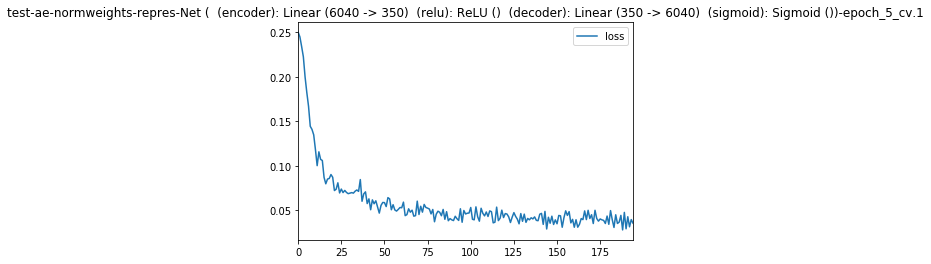

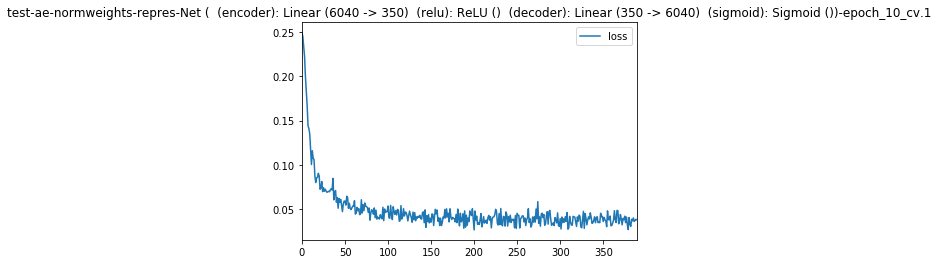

In [11]:
representations = dict()
pred_perf = dict()
cf_perf = dict()


net = Net(input_size, hidden_size, output_size)

certeria = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
print(net.train())
for epoch in range(num_epochs):
    for i_batch, sample_batched in enumerate(data3.train_loader):
#         print(i_batch,sample_batched)
        sample = Variable(sample_batched['sample'])
#         print(sample)
#         sample = Variable()
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(sample)
        loss = certeria(outputs, sample)
#         print(i_batch, loss.data[0])
        loss.backward()
        optimizer.step()
        
        print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                   % (epoch + 1, num_epochs, i_batch + 1, 
                      len(data3.train_loader) ,loss.data[0]))
        loss_history.append(loss.data[0])
    iters = epoch +1
    if (iters) % 5 == 0:
#         model = copy.deepcopy(net)
        name = 'test-ae-normweights-repres-%s-epoch_%s_cv.%s'%(str(net).replace('\n',''), epoch+1, cv)
        torch.save(net.state_dict(), name)
        representations[iters] = dict()
        print('recommendataion on prediction... Epoch %s'%(iters))
        loss_df= pd.DataFrame(loss_history,columns=['loss'])
        loss_df.plot(title=name)
        predicted = np.zeros_like(data3.train_dataset.train)
        for key in net.representations.keys():
            representations[iters][key] = np.zeros((data3.train_dataset.train.shape[1]
                                                           ,net.representations[key].shape[1]))
#             print(key,(data3.train_dataset.train.shape[1]
#                                                            ,net.representations[key].shape[1]))
#         print('-'*60)
        for item_id in xrange(data3.train_dataset.train.shape[1]):
            sample = Variable(torch.from_numpy(data3.train_dataset.known[:,item_id]))
            output = net(sample)
            for key in net.representations.keys():
                r = representations[iters][key]
#                 print(key, net.representations[key].shape)
                r[item_id, :] = net.representations[key]

            predicted[ :,item_id] = output.data.numpy()
        rec_p = rec_pred(predicted)
        pred_perf[iters] = (rec_p.precision_, rec_p.recall_)
#         pred_perf[iters] = pred_recommend(train=data.train_dataset.train , test=data.test_dataset.test, predicted= predicted)
#         rec on hiddens
        cf_perf[iters] = dict()
        for key in net.representations.keys():
            cf_perf[iters][key]=dict()
            hidden_layer = representations[iters][key]
            cf = rec3.IBCF(sim='cosine')
            cf.fit(train_ratings = data3.train_dataset.train, profile=hidden_layer)
#             cf.compute_score(input_ratings = data3.train_dataset.known, topN=topN, targets=data3.test_dataset.targets)
#             cf.produce_reclist(targets=data3.test_dataset.targets)
#             cf.evaluate(test= data3.test_dataset.test, rec_len=5)
            for knn in [5,50,100,500]:
                print('recommendataion on cf_hidden... Epoch %s, layper %s,topN %s'%(iters, key, knn))
                cf.compute_score(input_ratings = data3.train_dataset.known, topN=knn, targets=data3.test_dataset.targets)
                cf.produce_reclist(targets=data3.test_dataset.targets)
                tmp_perf = cf.evaluate(test= data3.test_dataset.test, rec_len=5)

                cf_perf[iters][key][knn] = tmp_perf


In [12]:
pred_perf

{5: (0.0016556291390728477, 9.4932863478947691e-06),
 10: (0.0013245033112582781, 7.5946290783158153e-06)}

In [13]:
cf_perf

{5: {'decode': {5: (0.38509933774834443, 0.038349116018660694),
   50: (0.41026490066225169, 0.040855414696477153),
   100: (0.39834437086092717, 0.03590009987080784),
   500: (0.29801324503311261, 0.024197043470132667)},
  'decode_sigmoid': {5: (0.35496688741721855, 0.032706740340070949),
   50: (0.39337748344370865, 0.035769079773197848),
   100: (0.36192052980132455, 0.031720338537693259),
   500: (0.3129139072847682, 0.024009533645331066)},
  'hidden': {5: (0.38046357615894044, 0.040521128335199635),
   50: (0.42715231788079472, 0.041783382342792177),
   100: (0.42284768211920537, 0.038995168717490258),
   500: (0.33211920529801331, 0.028293357969071682)},
  'hidden_relu': {5: (0.38841059602649003, 0.041237868668328764),
   50: (0.42185430463576162, 0.041928823133995825),
   100: (0.41821192052980133, 0.039820292947378808),
   500: (0.34105960264900664, 0.029447607423811924)}},
 10: {'decode': {5: (0.37019867549668872, 0.038047333400430344),
   50: (0.42251655629139079, 0.040843910

In [14]:
cf_perf_list = []
for iteration in cf_perf.keys():
    d1 = cf_perf[iteration]
    for hidden in d1.keys():
        d2 = d1[hidden]
        for knn in d2.keys():
            v3 = d2[knn]
            cf_perf_list.append((iteration, hidden, knn,v3[0], v3[1]))

In [15]:
cf_perf_df = pd.DataFrame(cf_perf_list, columns=['iteration','hidden','knn','precision','recall'])

In [16]:
cf_perf_df = cf_perf_df.sort_values(by=['iteration','hidden','knn'])

In [17]:
cf_perf_df[cf_perf_df.hidden == 'hidden_relu'].groupby('iteration').max()

,hidden,knn,precision,recall
iteration,,,,
5,hidden_relu,500,0.421854,0.041929
10,hidden_relu,500,0.423841,0.042107


In [18]:
representations

{5: {'decode': array([[-75.22507477, -81.08935547, -74.09468842, ..., -70.53026581,
          -69.45124817, -78.30011749],
         [-42.28190994, -45.60195923, -41.8759079 , ..., -39.69190216,
          -39.01483154, -44.1994133 ],
         [-29.22775841, -31.57356453, -29.25839043, ..., -27.67194939,
          -27.16803551, -30.5992012 ],
         ..., 
         [ -9.75941563, -10.37407112,  -9.99892807, ...,  -9.5418911 ,
           -9.54177189, -10.35269737],
         [-10.18376732, -10.7943821 , -10.55525112, ..., -10.09548855,
          -10.12264919, -10.89062691],
         [-25.74501801, -27.65166664, -25.81684113, ..., -24.59217453,
          -24.40810776, -26.93811226]]),
  'decode_sigmoid': array([[  2.13877505e-33,   6.07212068e-36,   6.62347133e-33, ...,
            2.33934755e-31,   6.88186538e-31,   9.87850096e-35],
         [  4.33710389e-19,   1.56790857e-20,   6.50914990e-19, ...,
            5.78130509e-18,   1.13782093e-17,   6.37439080e-20],
         [  2.02556315e-

run hidden with larger neighborhood

In [19]:
for epoch in range(num_epochs):
    
    iters = epoch +1
    if (iters) % 5 == 0:
#         model = copy.deepcopy(net)
#         cf_perf[iters] = dict()
        for key in net.representations.keys():
#             cf_perf[iters][key]=dict()
            hidden_layer = representations[iters][key]
            cf = rec3.IBCF(sim='cosine')
            cf.fit(train_ratings = data3.train_dataset.train, profile=hidden_layer)
#             cf.compute_score(input_ratings = data3.train_dataset.known, topN=topN, targets=data3.test_dataset.targets)
#             cf.produce_reclist(targets=data3.test_dataset.targets)
#             cf.evaluate(test= data3.test_dataset.test, rec_len=5)
            for knn in [1500,2000,3000]:
                print('recommendataion on cf_hidden... Epoch %s, layper %s,topN %s'%(iters, key, knn))
                cf.compute_score(input_ratings = data3.train_dataset.known, topN=knn, targets=data3.test_dataset.targets)
                cf.produce_reclist(targets=data3.test_dataset.targets)
                tmp_perf = cf.evaluate(test= data3.test_dataset.test, rec_len=5)

                cf_perf[iters][key][knn] = tmp_perf


recommendataion on cf_hidden... Epoch 5, layper decode,topN 1500
recommendataion on cf_hidden... Epoch 5, layper decode,topN 2000
recommendataion on cf_hidden... Epoch 5, layper decode,topN 3000
recommendataion on cf_hidden... Epoch 5, layper decode_sigmoid,topN 1500
recommendataion on cf_hidden... Epoch 5, layper decode_sigmoid,topN 2000
recommendataion on cf_hidden... Epoch 5, layper decode_sigmoid,topN 3000
recommendataion on cf_hidden... Epoch 5, layper hidden,topN 1500
recommendataion on cf_hidden... Epoch 5, layper hidden,topN 2000
recommendataion on cf_hidden... Epoch 5, layper hidden,topN 3000
recommendataion on cf_hidden... Epoch 5, layper hidden_relu,topN 1500
recommendataion on cf_hidden... Epoch 5, layper hidden_relu,topN 2000
recommendataion on cf_hidden... Epoch 5, layper hidden_relu,topN 3000
recommendataion on cf_hidden... Epoch 10, layper decode,topN 1500
recommendataion on cf_hidden... Epoch 10, layper decode,topN 2000
recommendataion on cf_hidden... Epoch 10, layper 

In [20]:
import copy

In [21]:
cf_perf_df[cf_perf_df.groupby('iteration')['precision'].transform(max) == cf_perf_df['precision']]

,iteration,hidden,knn,precision,recall
25,5,hidden,50,0.427152,0.041783
14,10,hidden_relu,100,0.423841,0.040949


In [22]:
cf_perf_df

,iteration,hidden,knn,precision,recall
19,5,decode,5,0.385099,0.038349
17,5,decode,50,0.410265,0.040855
18,5,decode,100,0.398344,0.035900
16,5,decode,500,0.298013,0.024197
23,5,decode_sigmoid,5,0.354967,0.032707
21,5,decode_sigmoid,50,0.393377,0.035769
22,5,decode_sigmoid,100,0.361921,0.031720
20,5,decode_sigmoid,500,0.312914,0.024010
27,5,hidden,5,0.380464,0.040521
25,5,hidden,50,0.427152,0.041783


In [23]:
pred_perf

{5: (0.0016556291390728477, 9.4932863478947691e-06),
 10: (0.0013245033112582781, 7.5946290783158153e-06)}

In [24]:
cf_perf2 = copy.deepcopy(cf_perf)

In [25]:
import json

In [26]:
f = open('./ae_iter/cf_perf_norm_weights.json','w')
json.dump(cf_perf, f)

In [27]:
loss_history

[0.25008341670036316,
 0.24485081434249878,
 0.23405973613262177,
 0.2225150763988495,
 0.19983312487602234,
 0.18241827189922333,
 0.1669280230998993,
 0.14439372718334198,
 0.1408979892730713,
 0.13477376103401184,
 0.1182585209608078,
 0.10014565289020538,
 0.11570506542921066,
 0.10721416771411896,
 0.10593122988939285,
 0.08696985244750977,
 0.0797555148601532,
 0.08506771922111511,
 0.08574022352695465,
 0.09015960246324539,
 0.08708325773477554,
 0.07215855270624161,
 0.07368522137403488,
 0.08088050037622452,
 0.06947703659534454,
 0.07383384555578232,
 0.06987300515174866,
 0.07229947298765182,
 0.07005270570516586,
 0.06866432726383209,
 0.06931013613939285,
 0.06985457241535187,
 0.0692792534828186,
 0.07145799696445465,
 0.07280570268630981,
 0.07122647762298584,
 0.08450884371995926,
 0.06011496111750603,
 0.06841664016246796,
 0.07069456577301025,
 0.057530660182237625,
 0.06283140927553177,
 0.05061078071594238,
 0.06170273572206497,
 0.05733813717961311,
 0.060643967241

In [28]:
loss_history2 = copy.deepcopy(loss_history)

In [29]:
loss_np = np.array(loss_history)

In [30]:
loss_np = (loss_np > 0.2).astype(int)

In [31]:
loss_np.nonzero()

(array([0, 1, 2, 3]),)

In [32]:
429-234

195

In [33]:
195/39.0

5.0

In [34]:
(234-39)/39.0

5.0